# Analyzing Submitted Job Applications by Days of the Week

## Introduction
For a busy Talent Acquisition team, the more you understand your applicant pool, the more effective you will be. Knowing your applicants allows you to optimize your talent pipeline, getting the most out of your sourcing dollars and delivering the best outcomes for your business. Where and when are they typically job searching? Are there certain days of the week or times of day when they are most active? 

I processed data from over 15,000 hourly job applicants in foodservice and manufacturing from across the country in states such as California, Illinois and Georgia, from 2018 to 2020, to better understand when the applicants are submitting their applications. Looking at 2019 specifically, which yielded over 12 thousand initiated applications, I segmented the job search by week, day, and hour to get a sense of the general behavior of applicants to find out what were the most popular days and times for initiating the application process.

To get a more representative sense of popularity during a given time of the week for 2019, I calculated each hour’s proportional share of total applications for the week. In other words, to get the best idea of generally how popular 9am Thursday morning was for 2019, I calculated the median of all of 2019's Thursday 9am application volumes. 

<b> Findings:</b><br>
 - Most applications are made on Mondays, Tuesdays , and Wednesdays, with Tuesday being the most popular<br>
 - Most applications are initiated between the hours of 9am and 2pm <br>
 - The peak hours in a given week happen on Tuesdays from 8am to 2pm, with 9am representing the busiest hour of the week at 2.25%, nearly 2.75X higher than the average hourly share per week of 0.6% 
 
<b> Recommendations:</b><br>
 - Expect your busiest window for receiving applications to begin in the morning<br>
 - Consider scheduling more interviews on Wednesdays through Fridays to capture the Tuesday submissions<br>
 - Time any job postings or “refreshes” of your job postings to happen at the beginning of the week to increase reach<br> 

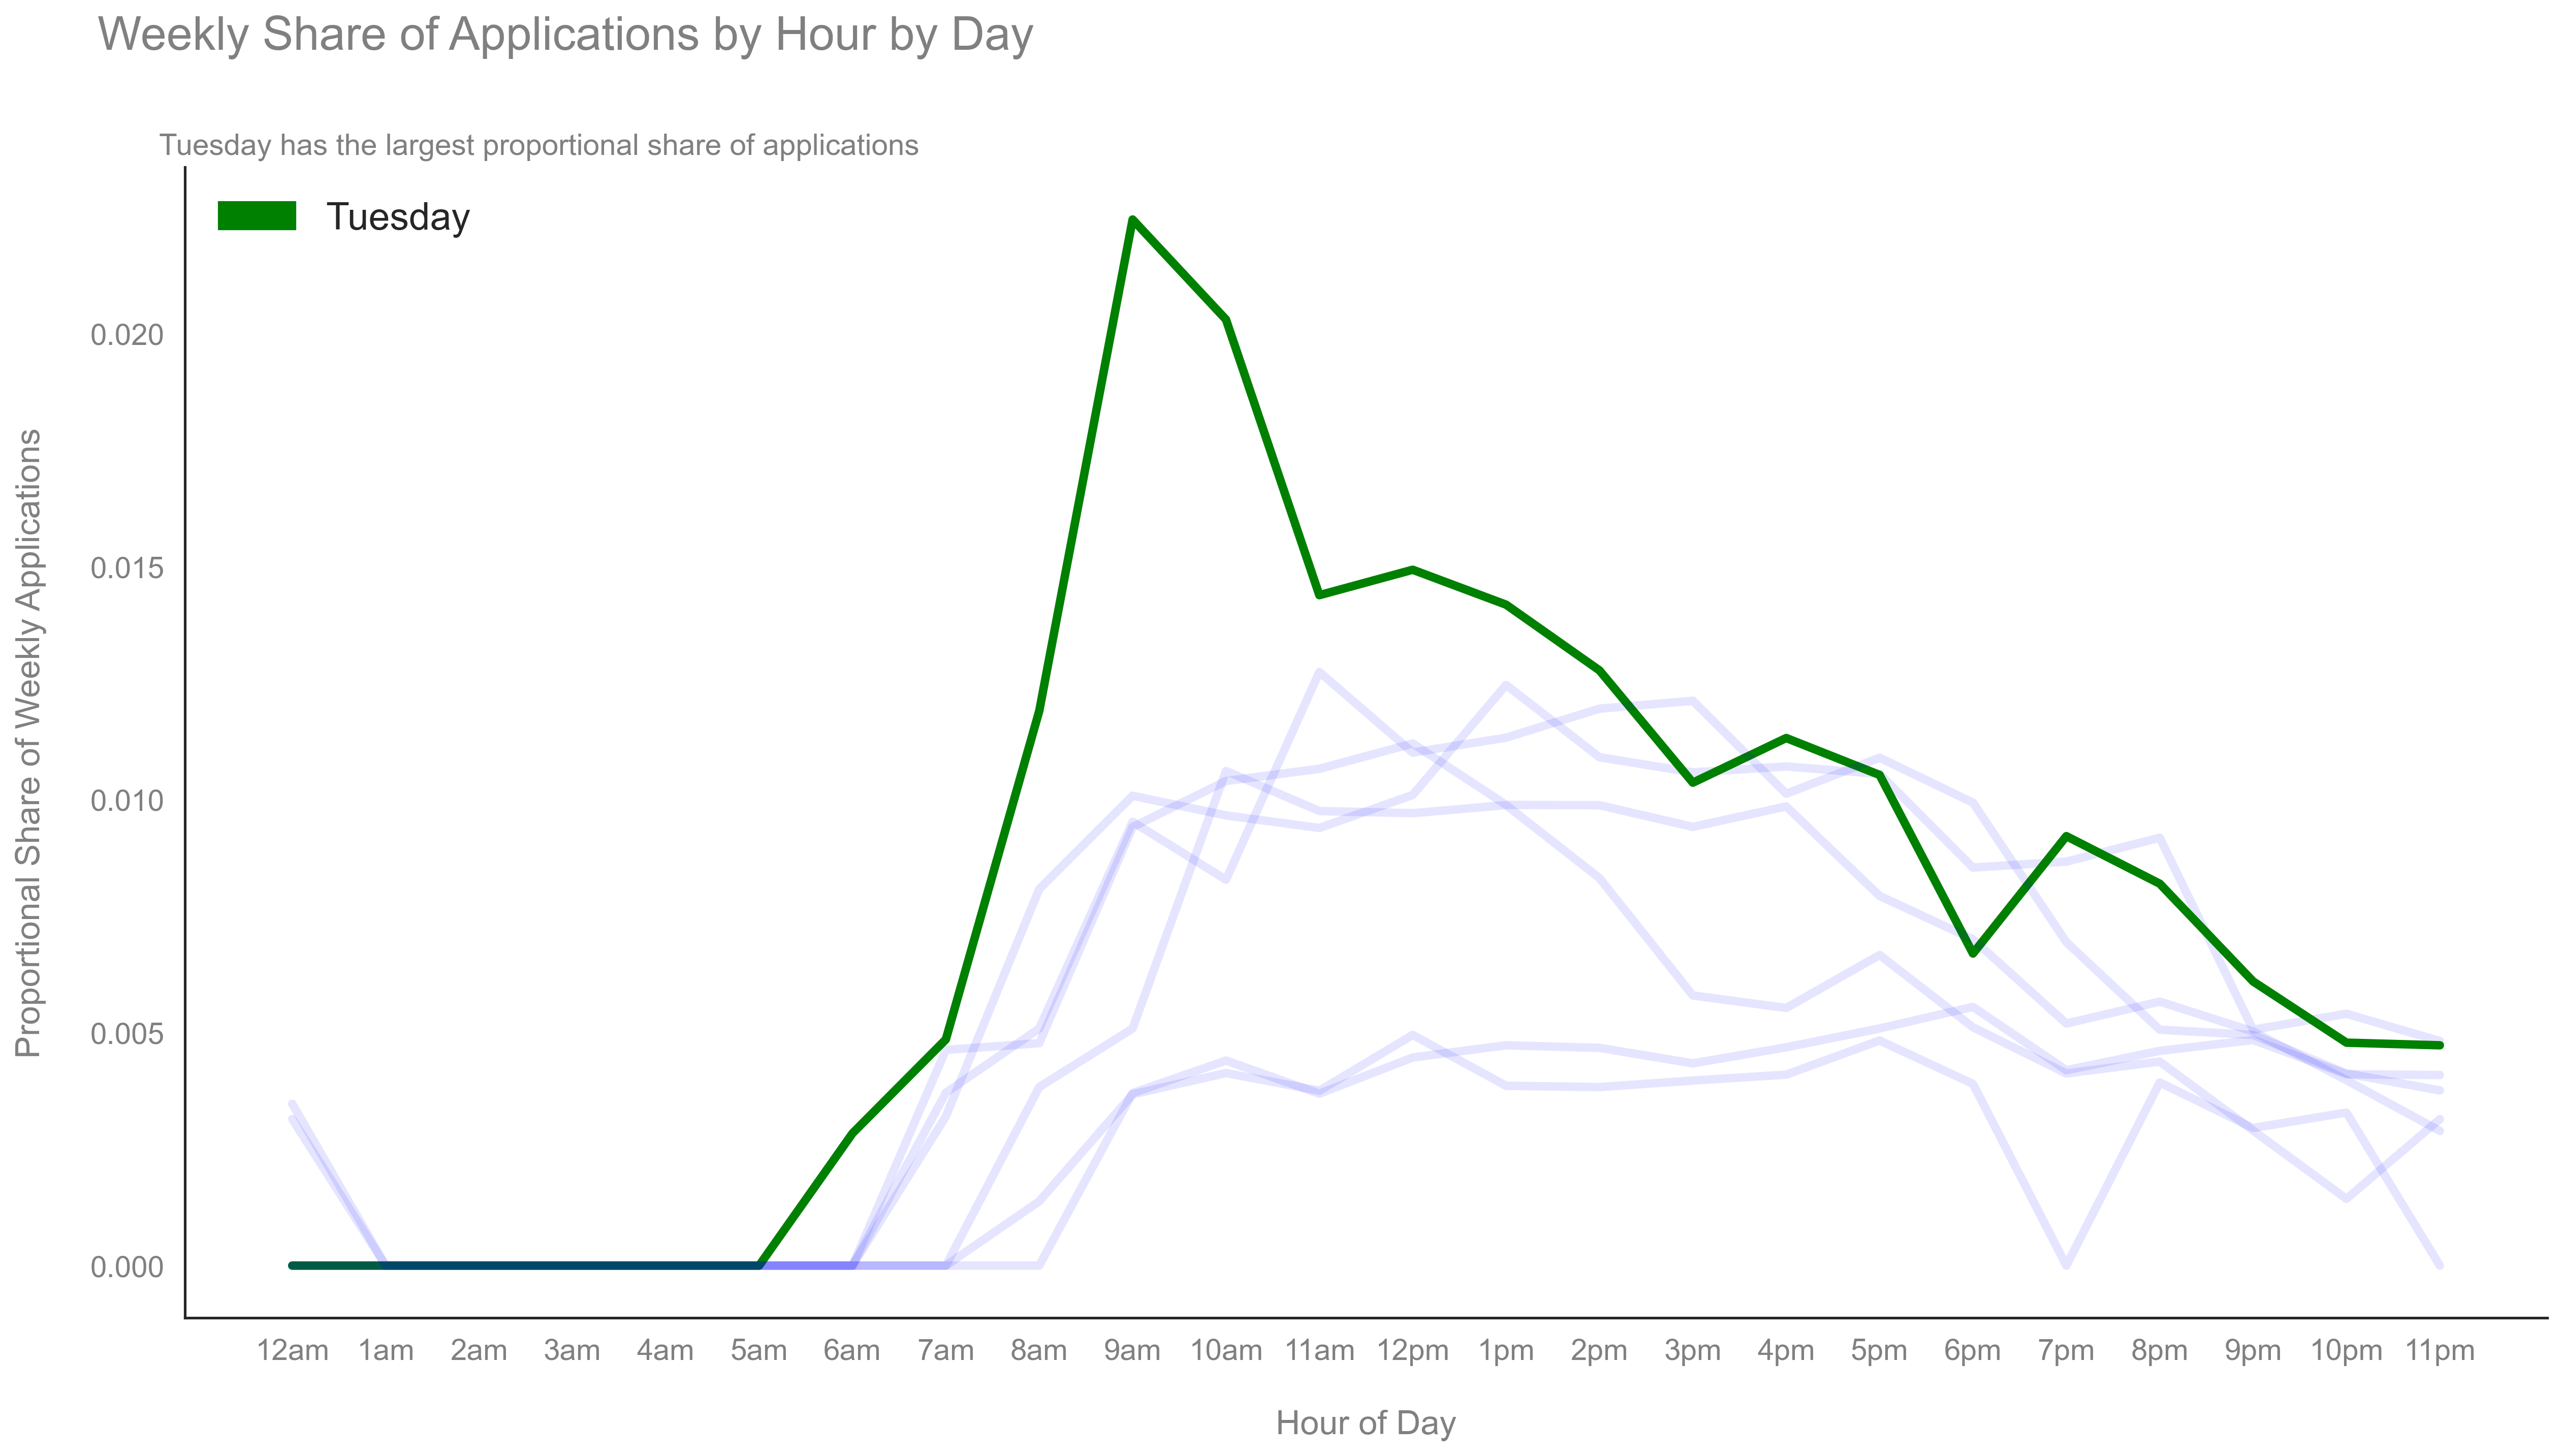

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell
import csv
#import datetime
import pandas as pd
import numpy as np
import datetime as dt
from pytz import all_timezones

# Options for pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.width = 200

# Display all cell outputs
InteractiveShell.ast_node_interactivity = 'all'

ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
%matplotlib inline
sns.set()


# Functions

In [2]:
def adjust_time(data, city):
    '''converts UTC time to reflect actual timezone of the location'''

    # function takes a dataframe and a dictionary of cities/timezones to be changed as args
    adjusted_df_list = []

    for key in city:
        #print(f" City: {key}   Timezone: {city[key]}")
        dates = data.copy()
        dates = dates[dates['city'] == key]
        dates['start_date'] = dates['start_date'].dt.tz_convert(
            city[key])  # adjust to new timezone
        dates['start_date'] = dates['start_date'].dt.tz_localize(
            None)  # drop timezone
        dates['completion_date'] = dates['completion_date'].dt.tz_convert(
            city[key])  # adjust to new timezone
        dates['completion_date'] = dates['completion_date'].dt.tz_localize(
            None)  # drop timezone

        adjusted_df_list.append(dates)

    return adjusted_df_list


def get_day(data, days):
    '''slices the data for a given day'''

    hours_12 = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am',
                '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']

    filter_col = [col for col in data if col.startswith(days)]
    data = data[filter_col].T
    data['hours'] = hours_12
    data = data.set_index('hours')
    return data


def make_cols():
    cols = []  # create column values
    for day in range(7):
        for hour in range(24):
            cols.append(f'{day}_{hour}')
    return cols


def days_plot(data):
    ''' This function plots the proportional share of applications by day'''
    x = data.index
    a = data.monday
    b = data.tuesday
    c = data.wednesday
    d = data.thursday
    e = data.friday
    f = data.saturday
    g = data.sunday
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.plot(x, a, lw=4, label='Monday', color='blue', alpha=0.1)
    plt.plot(x, b, lw=4, label='Tuesday', color='green')
    plt.plot(x, c, lw=4, label='Wednesday', color='blue', alpha=0.1)
    plt.plot(x, d, lw=4, label='Thursday', color='blue', alpha=0.1)
    plt.plot(x, e, lw=4, label='Friday', color='blue', alpha=0.1)
    plt.plot(x, f, lw=4, label='Saturday', color='blue', alpha=0.1)
    plt.plot(x, g, lw=4, label='Sunday', color='blue', alpha=0.1)
    plt.xticks(fontsize=14, color='gray')
    plt.yticks(fontsize=14, color='gray')
    plt.ylabel(f'Weekly proportional share of applications\n',
               fontsize=16, color='gray', x=0.25)
    plt.xlabel('\nHour of day', fontsize=16, color='gray')
    plt.suptitle('Weekly share of applications by hour by day',
                 fontsize=24, color='gray', x=0.25)
    plt.title('Tuesday has the largest proportional share of applications\n',
              fontsize=14, color='gray', x=0.15)
    green_patch = mpatches.Patch(color='green', label='Tuesday')
    plt.legend(handles=[green_patch],loc='upper left', frameon=False,prop={"size": 18})
    sns.despine()
    fig.savefig('Weekly_Share_by_hour_2', dpi=300, bbox_inches='tight')


def proportion_fun(dataframe, years):
    '''Using a loop to generate the proportion of total week's applications for each hour'''
    # function takes a dataframe and years as args
    updated_count = 0
    data = []
    keys = []

    # create a dictionary using the cols as keys and write zeros as values

    base_dict = {key: 0 for key in keys}
    dataframe = dataframe.set_index('start_date')

    for year in years:
        df1 = dataframe.copy()
        df1 = df1.loc[year]
        #print(f'Year being analyzed: {year}')
        weeks = sorted(df1['week'].unique())
        #print(f'total count of weeks: {weeks}')

        for week in weeks:
            # print(week)
            _week = df1.loc[df1['week'] == week]
            i = pd.crosstab(_week['day_as_number'],
                            _week['hour_of_day'], normalize=True)

            a = (i.index.array)  # these are the 'days' index elements
            b = (i.T.index.array)  # these are the 'hours' index elements
            # these are the corresponding crosstab values
            c = (i.values.flatten())

            # make a list of the actual 'day/hour' values per week
            cols = []
            for day in a:
                for hour in b:
                    cols.append(f'{day}_{hour}')

            # create a dictionary --> keys:cols, values:C
            d = dict(zip(cols, c))
            e = base_dict.copy()
            e.update(d)
            data.append(e.copy())
            updated_count += 1  # count num weeks

    return data, updated_count

# Data Processing


In [3]:
# import the file
file = "C:/Users/Jeff/Desktop/Projects/Data Science Portfolio/Exploring Application Times/employee_applications.csv"
# read the file
df = pd.read_csv(file,parse_dates = ['start_date','completion_date'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18671 entries, 0 to 18670
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   application_id   18671 non-null  int64              
 1   start_date       18671 non-null  datetime64[ns, UTC]
 2   completion_date  14038 non-null  datetime64[ns, UTC]
 3   city             18671 non-null  object             
dtypes: datetime64[ns, UTC](2), int64(1), object(1)
memory usage: 583.6+ KB


,application_id,start_date,completion_date,city
0,10001276,2016-12-26 05:04:33.442000+00:00,2018-09-18 04:57:53.333000+00:00,Chicago
1,10004458,2017-11-22 16:32:59.449000+00:00,NaT,Chicago
2,10024489,2018-01-27 01:51:00.795000+00:00,2019-08-14 19:00:35.292000+00:00,Los Angeles
3,10025997,2018-01-28 21:21:02.745000+00:00,2019-03-12 12:10:28.517000+00:00,Los Angeles
4,10026009,2018-01-28 23:28:50.810000+00:00,2018-12-29 16:23:40.967000+00:00,Los Angeles


All the timestamps in the dataset are represented in UTC and not represented as the actual location times. I will need to adjust all timestamps to reflect their respective timezone from where they originated. I will separate out the respective locations, adjust the timezones and then concatenate the results back into one dataset for a proper analysis 

In [4]:
df['city'].value_counts()

Atlanta          8039
Chicago          7887
Los Angeles      2636
Philadelphia       62
New York City      47
Name: city, dtype: int64

In [5]:
cities = {'Atlanta': 'America/New_York',
          'Chicago': 'America/Chicago',
          'Los Angeles': 'America/Los_Angeles',
          'New York City': 'America/New_York',
          'Philadelphia': 'America/New_York'
          }

# convert the UTC to local timezones
adjusted_df_list = adjust_time(df, cities)

# concatenate the time adjusted dataframes
df_adjusted = pd.concat(adjusted_df_list)

# Create new columns for week, day_of_week, and hour_of_day
#df_adjusted['week'] = df_adjusted['start_date'].dt.week
df_adjusted['week'] = df_adjusted['start_date'].dt.isocalendar().week
df_adjusted['day_of_week'] = df_adjusted['start_date'].dt.day_name()
df_adjusted['day_as_number'] = df_adjusted['start_date'].dt.dayofweek
df_adjusted['hour_of_day'] = df_adjusted['start_date'].dt.hour

# # compare samples from before and after
# df[df['city']== 'Atlanta'].head()
# df_adjusted.head()
df = df_adjusted.copy()

## Building the dataset: calculating hourly share of total weeks' hours

In [6]:
# create a new empty dataframe
cols = make_cols()
hourly_share = pd.DataFrame(columns=cols)

# input years to analyze
years = ['2019']

data, updated_count = proportion_fun(df, years)
hourly_share = hourly_share.append(data, ignore_index=True)

# print()
# print(f"total updated weeks: {updated_count}")
# print()
# print(f"concatenated {updated_count} weeks of data!")
# print()

hourly_median = hourly_share.median()
hourly_median = pd.DataFrame(hourly_median).T

# prepare the data for each day
monday = get_day(hourly_median, '0')
tuesday = get_day(hourly_median, '1')
wednesday = get_day(hourly_median, '2')
thursday = get_day(hourly_median, '3')
friday = get_day(hourly_median, '4')
saturday = get_day(hourly_median, '5')
sunday = get_day(hourly_median, '6')

# put the days back together
week = pd.concat([monday, tuesday, wednesday, thursday,
                  friday, saturday, sunday], axis=1, ignore_index=True)
# rename the columns
week = week.rename(columns={week.columns[0]: 'monday', week.columns[1]: 'tuesday',
                            week.columns[2]: 'wednesday', week.columns[3]: 'thursday',
                            week.columns[4]: 'friday', week.columns[5]: 'saturday',
                            week.columns[6]: 'sunday'})

print('\033[1m Final dataset of median values for hours of the week \033[0m')
week

 Final dataset of median values for hours of the week 


,monday,tuesday,wednesday,thursday,friday,saturday,sunday
hours,,,,,,,
12am,0.000000,0.000000,0.003145,0.003472,0.000000,0.000000,0.000000
1am,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2am,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3am,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4am,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5am,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6am,0.000000,0.002839,0.000000,0.000000,0.000000,0.000000,0.000000
7am,0.003202,0.004855,0.003711,0.004630,0.000000,0.000000,0.000000
8am,0.008082,0.011903,0.005089,0.004773,0.003832,0.001381,0.000000


# Analysis/Modeling

In [7]:
# find the summary statistics for 2019
df_adjusted = df_adjusted.set_index('start_date')
df_2019 = df_adjusted.loc['2019']

mean_week = df_2019['week'].value_counts().mean()
median_week = df_2019['week'].value_counts().median()

print(f'\033[1mTotal applications initiated in 2019: {len(df_2019)}\033[0m')
print(f'\033[1mThe mean amount of applications per week in 2019: {mean_week:.2f}\033[0m')
print(f'\033[1mThe median amount of applications per week in 2019: {median_week}\033[0m')

df_2019['week'].value_counts().describe()

# First quartile (Q1)
Q1 = np.percentile(df_2019['week'].value_counts(),25, interpolation='midpoint')
# Third quartile (Q3)
Q3 = np.percentile(df_2019['week'].value_counts(),75, interpolation='midpoint')
# Interquaritle range (IQR)
IQR = Q3 - Q1

print(f'IQR: {IQR}')

per_day = median_week/7
per_hour = per_day / 24

hourly_share = per_hour / median_week

print(f'\033[1mtypical hourly share of week: {hourly_share:.4f}\033[0m')

Total applications initiated in 2019: 12052
The mean amount of applications per week in 2019: 231.77
The median amount of applications per week in 2019: 216.0


count     52.000000
mean     231.769231
std       52.134297
min      120.000000
25%      196.750000
50%      216.000000
75%      264.500000
max      362.000000
Name: week, dtype: float64

IQR: 69.5
typical hourly share of week: 0.0060


<b> Establishing a benchmark share per hour is important in guaging how popular some hours of the week will be comparitively.</b>

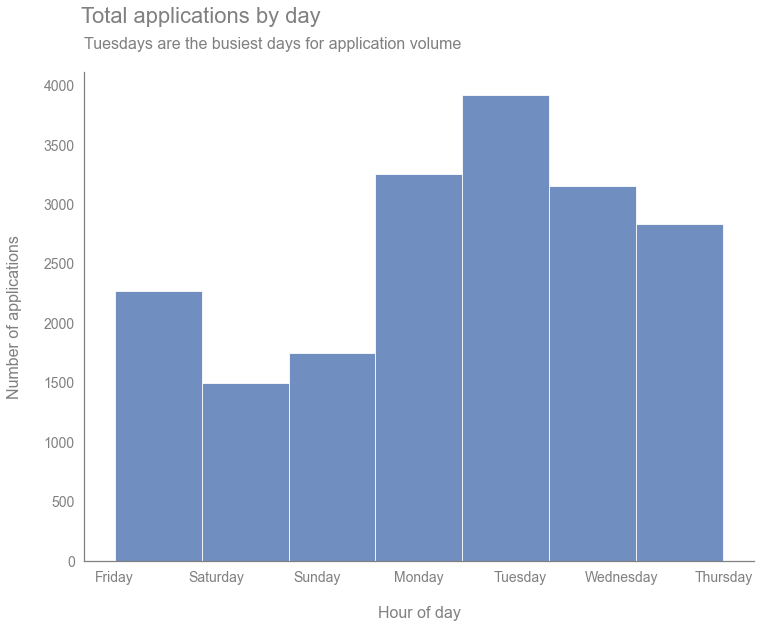

In [11]:
# Create a bar chart of all applications submitted by day of the week
fig, ax = plt.subplots()
sns.set_style("white")
df_adjusted['day_of_week'].hist(bins=7, grid=False, figsize=(12, 9),alpha = 0.8)
plt.suptitle('Total applications by day',fontsize=22, x = 0.26, color = 'gray')
plt.title('Tuesdays are the busiest days for application volume\n', fontsize=16, loc = "left",color = "gray")
plt.xticks(fontsize=14,color = "gray")
plt.yticks(fontsize=14,color = "gray")
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.xlabel('\nHour of day', fontsize=16,color = "gray")
plt.ylabel('Number of applications\n', fontsize=16, color = "gray")
sns.despine();

<b> Above, Monday, Tuesday, and Wednesday represent the peak days of the week for total application submissions with Tuesday having the most applications. Satuday and Sunday represent the lowest level of submissions for the week.</b>

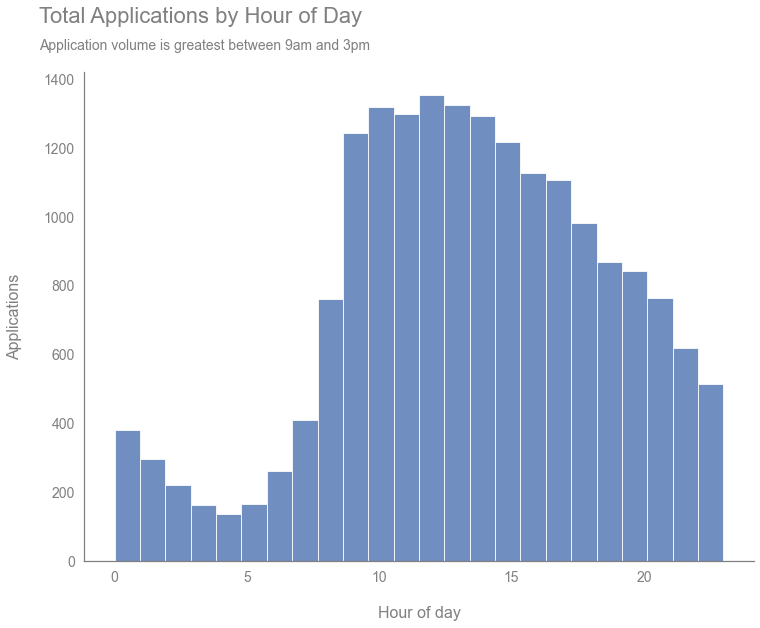

In [9]:
# Create a bar chart of all applications submitted by hour of day
fig, ax = plt.subplots()
sns.set_style("white")
df_adjusted['hour_of_day'].hist(bins=24, grid=False, figsize=(12, 9), alpha = 0.8)
plt.suptitle('Total Applications by Hour of Day',fontsize=22, x = 0.26, color = 'gray')
plt.title('Application volume is greatest between 9am and 3pm\n', fontsize=14, x = 0.18,color = "gray")
plt.xticks(fontsize=14,color = "gray")
plt.yticks(fontsize=14,color = "gray")
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('\nHour of day', fontsize=16, color = "gray")
plt.ylabel('Applications\n', fontsize=16,color = "gray")
sns.despine();

<b> Above the bar chart shows the total number of aplications for a given hour of the day. The most application submissions are happening between 9am and 3pm, with the 12pm hour as the peak hour for submissions. Applications then steadily drop into the evening</b>

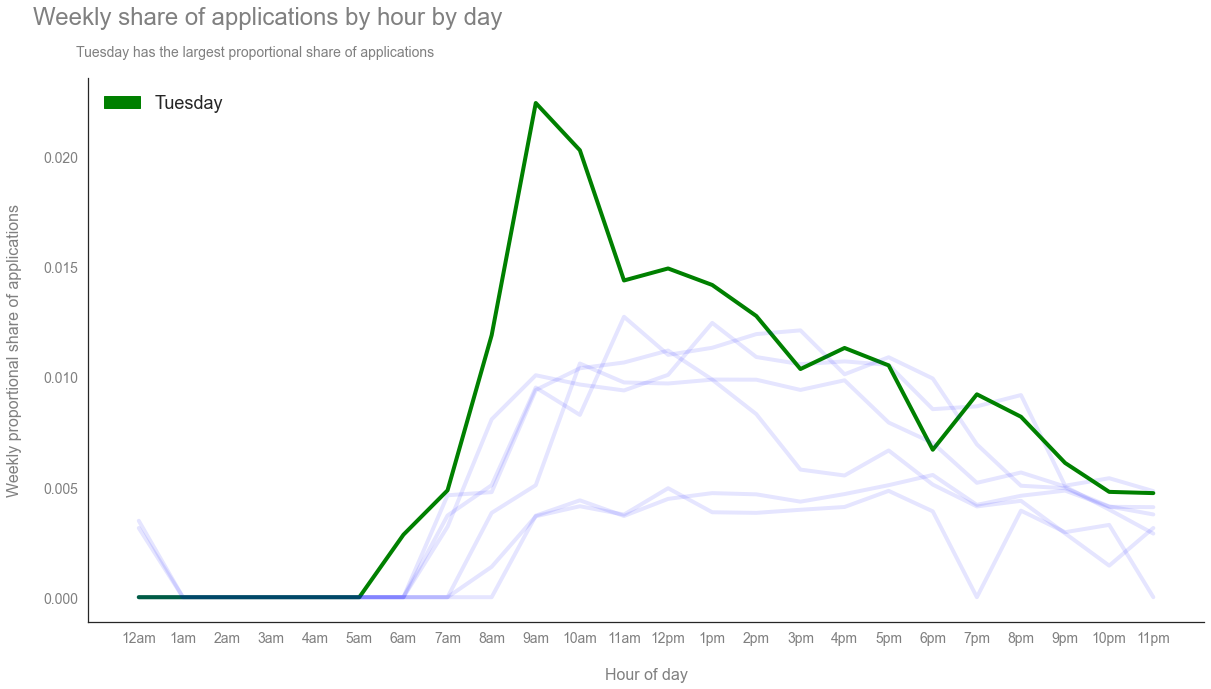

In [10]:
# plot the data per day
days_plot(week)    

<b>Above, the line chart shows the median share of application submissions per hour of day for the week. Clearly, Tuesday has the greatest proportion of the weekly application submissions. This is especially noticeable in the morning hours from approximately 8am to about 2pm being the most popular time of the week for submitting applications.</b> <br>

<b>The peak hour of activity for applicants in 2019 was 9am on Tuesday, which at 2.25% is nearly 2.75X higher than the hourly average for any hour in a given week for the year. </b>